In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import seaborn as sns

#import tensorrt
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense

from tensorflow.keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [60]:
def mase(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    return mae_model / mae_naive if mae_naive != 0 else float('inf')

def pocid(y_true, y_pred):
    n_pairs = len(y_true) - 1
    
    correct_directions = 0
    
    for i in range(1, len(y_true)):
        actual_direction = np.sign(y_true[i] - y_true[i - 1])
        predicted_direction = np.sign(y_pred[i] - y_pred[i - 1])
        
        if actual_direction == predicted_direction:
            correct_directions += 1

    pocid_score = (correct_directions / n_pairs)
    return pocid_score



def printRegressionMetrics(y_true, y_pred):
    
    MAPE = metrics.mean_absolute_percentage_error(y_true, y_pred)
    RMSE = metrics.root_mean_squared_error(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    MASE = mase(y_true, y_pred)
    POCID = pocid(y_true, y_pred)
    
    print('RMSE:')
    print(RMSE)
    print('MAPE:')
    print(MAPE)
    print('MASE:')
    print(MASE)
    print('R2:')
    print(R2)
    print('POCID:')
    print(POCID)
    

NEW_MODEL = False
MODEL_NAME = 'MickaNet-LSTM-V1'

In [61]:
WINDOW_SIZE = 24
x_frames = []
y_frames = []

In [62]:
data = pd.read_csv("./Dataset/dataOld.csv")
data = data.head(26305)


In [63]:
data

,timestamp,volume,trades,price
0,1577847600000,1.959652e+06,2811,7228.50
1,1577848500000,1.225410e+06,1897,7237.15
2,1577849400000,1.469870e+06,2163,7221.27
3,1577850300000,1.012436e+06,1466,7225.01
4,1577851200000,1.102373e+06,1985,7219.09
...,...,...,...,...
26300,1601517600000,6.680208e+06,7136,10819.73
26301,1601518500000,2.736092e+06,3947,10814.56
26302,1601519400000,2.167547e+06,3671,10828.42
26303,1601520300000,2.148491e+06,3595,10817.14


In [64]:
data.shape

(26305, 4)

In [65]:
teste = data.copy()
teste["timestamp"] = teste["timestamp"] / 1000
teste["timestamp"] = teste['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
teste.reset_index(drop=True, inplace=True)

In [66]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_volume= MinMaxScaler(feature_range=(0,1))
scaler_trades = MinMaxScaler(feature_range=(0,1))

price_scaled = np.array(teste["price"]).copy()
volume_scaled = np.array(teste["volume"]).copy()
trades_scaled = np.array(teste["trades"]).copy()


teste['price'] = scaler_price.fit_transform(price_scaled.reshape(-1,1)).flatten()
teste['volume'] = scaler_volume.fit_transform(volume_scaled.reshape(-1,1)).flatten()
teste['trades'] = scaler_trades.fit_transform(trades_scaled.reshape(-1,1)).flatten()

In [67]:
teste = teste.set_index('timestamp')
teste

,volume,trades,price
timestamp,,,
2020-01-01 00:00:00,0.009178,0.015846,0.391867
2020-01-01 00:15:00,0.005096,0.009680,0.392880
2020-01-01 00:30:00,0.006455,0.011474,0.391020
2020-01-01 00:45:00,0.003912,0.006773,0.391458
2020-01-01 01:00:00,0.004412,0.010274,0.390765
...,...,...,...
2020-09-30 23:00:00,0.035421,0.045021,0.812419
2020-09-30 23:15:00,0.013494,0.023509,0.811813
2020-09-30 23:30:00,0.010334,0.021647,0.813436


In [68]:
teste.reset_index(drop=True, inplace=True)
teste

,volume,trades,price
0,0.009178,0.015846,0.391867
1,0.005096,0.009680,0.392880
2,0.006455,0.011474,0.391020
3,0.003912,0.006773,0.391458
4,0.004412,0.010274,0.390765
...,...,...,...
26300,0.035421,0.045021,0.812419
26301,0.013494,0.023509,0.811813
26302,0.010334,0.021647,0.813436
26303,0.010228,0.021134,0.812115


In [69]:
x_names = teste.columns.to_list()

x_data = teste[x_names].to_numpy()
y_data = teste['price'].to_numpy()

num_samples = len(teste) - WINDOW_SIZE

x_frames = np.zeros((num_samples, WINDOW_SIZE, len(x_names)))
y_frames = np.zeros((num_samples, 1))

for i in range(num_samples):
    x_frames[i] = x_data[i:i+WINDOW_SIZE] 
    y_frames[i] = y_data[i+WINDOW_SIZE] 

In [70]:
x_frames

array([[[0.00917784, 0.01584571, 0.39186681],
        [0.00509592, 0.00968012, 0.39287977],
        [0.00645496, 0.01147448, 0.39102014],
        ...,
        [0.00792984, 0.01328234, 0.38735475],
        [0.00525963, 0.009073  , 0.38681957],
        [0.01090996, 0.01518463, 0.38860426]],

       [[0.00509592, 0.00968012, 0.39287977],
        [0.00645496, 0.01147448, 0.39102014],
        [0.00391192, 0.00677271, 0.39145811],
        ...,
        [0.00525963, 0.009073  , 0.38681957],
        [0.01090996, 0.01518463, 0.38860426],
        [0.00624055, 0.0113733 , 0.38778921]],

       [[0.00645496, 0.01147448, 0.39102014],
        [0.00391192, 0.00677271, 0.39145811],
        [0.00441191, 0.01027374, 0.39076485],
        ...,
        [0.01090996, 0.01518463, 0.38860426],
        [0.00624055, 0.0113733 , 0.38778921],
        [0.00423857, 0.00827026, 0.38817565]],

       ...,

       [[0.02374814, 0.03574561, 0.79876173],
        [0.01000186, 0.02404852, 0.79913998],
        [0.01326343, 0

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x_frames, y_frames, test_size=0.2, shuffle=False)

In [72]:
units_lstm1 = 32
units_dense = 32
ACT_FUNC = "tanh"
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Input
inputs = Input(shape=(x_frames.shape[1], x_frames.shape[2]), name="x_train")

# Primeira e única camada LSTM
layer_lstm1 = LSTM(units_lstm1, 
                   activation=ACT_FUNC, 
                   return_sequences=False, 
                   kernel_initializer=initializer)(inputs)

# Camada densa intermediária
layer_dense = Dense(units_dense, activation="tanh")(layer_lstm1)

# Camada de saída linear
layer_dense_out = Dense(y_frames.shape[1], activation="linear")(layer_dense)

# Modelo final
model_trained = Model(inputs=inputs, outputs=layer_dense_out)


In [73]:
model_trained.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_train (InputLayer)            │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,697 (22.25 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
if NEW_MODEL:
    
    # Callbacks ajustados
    es = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)
    cp = ModelCheckpoint(filepath=f'models/{MODEL_NAME}.weights.h5', 
                         save_weights_only=True, 
                         monitor='val_loss', 
                         mode='min', 
                         save_best_only=True)
    
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                     factor=0.5, 
                                     patience=20, 
                                     min_lr=1e-7, 
                                     verbose=1)

    # Otimizador com ajuste fino
    opt = Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)


    # Compilação do mod+elo com perda Huber
    model_trained.compile(optimizer=opt, loss='huber')

    # Treinamento com ajuste dos callbacks
    history = model_trained.fit(x_train, 
                                y_train, 
                                validation_split=0.25, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=[cp, es, lr_scheduler], 
                                batch_size=32, 
                                shuffle=False)
    
    np.save('models/history_model.npy', history.history)
    model_trained.load_weights(f'models/{MODEL_NAME}.weights.h5')
    model_trained.save(f'models/{MODEL_NAME}.keras')
else:
    model_trained = load_model(f'models/{MODEL_NAME}.keras')

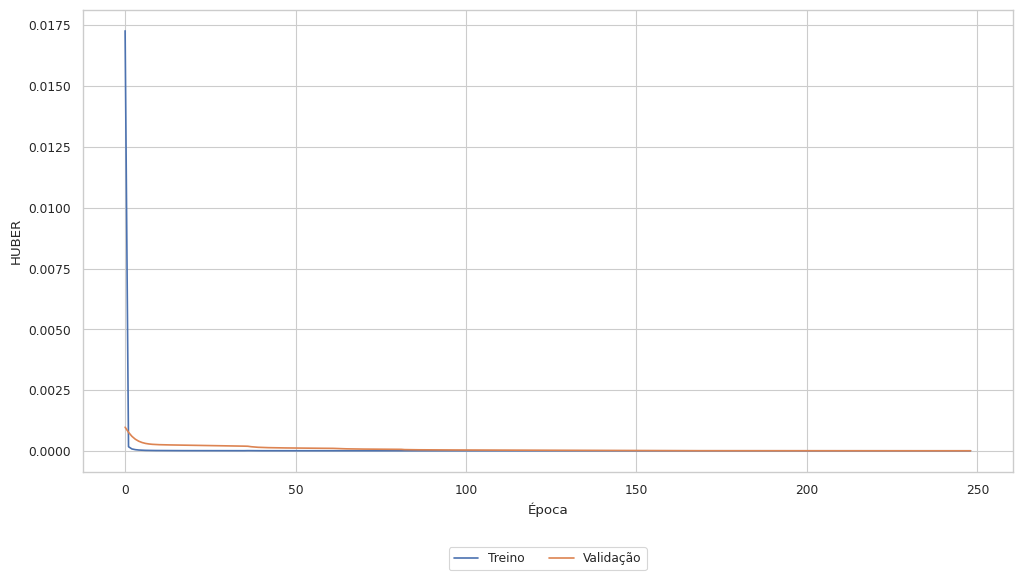

In [75]:
history=np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Huber'

fig = plt.figure()

plt.plot(train_metric, label='Treino'), 
plt.plot(valid_metric, label='Validação')
plt.ylabel(name_metric.upper())
plt.xlabel('Época')
#plt.title('Gráfico de convergência utilizando ' + name_metric.upper())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

In [76]:
y_hat = model_trained.predict(x_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [77]:
y_train2 = scaler_price.inverse_transform(y_train.flatten().reshape(-1, 1))
y_test2 = scaler_price.inverse_transform(y_test.flatten().reshape(-1, 1))
y_hat2 = scaler_price.inverse_transform(y_hat.flatten().reshape(-1, 1))

In [78]:
print(y_test2 - y_hat2)

[[336.71589844]
 [333.26003906]
 [326.98734375]
 ...
 [132.60359375]
 [116.89195312]
 [103.10132812]]


In [79]:
y_test2 - y_hat2

array([[336.71589844],
       [333.26003906],
       [326.98734375],
       ...,
       [132.60359375],
       [116.89195312],
       [103.10132812]])

In [80]:
y_hat2

array([[11484.954],
       [11486.21 ],
       [11485.473],
       ...,
       [10695.816],
       [10700.248],
       [10697.139]], dtype=float32)

In [81]:
y_test2

array([[11821.67],
       [11819.47],
       [11812.46],
       ...,
       [10828.42],
       [10817.14],
       [10800.24]])

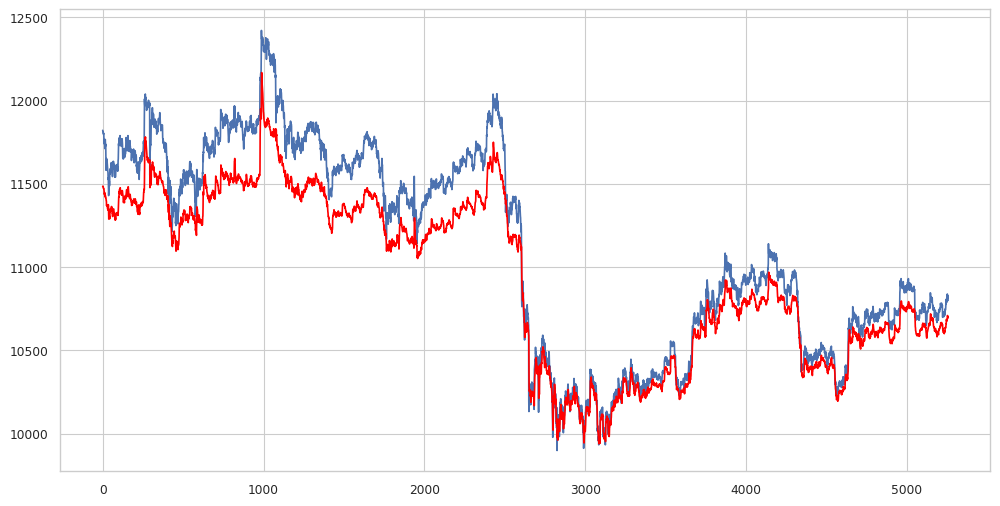

In [82]:
plt.plot(y_test2)
plt.plot(y_hat2, color='red')

In [83]:
#cria um data table com os valores reais e preditos
df_forecast = pd.DataFrame()
df_forecast['y_hat'] = np.hstack((y_train2.flatten(), y_hat2.flatten()))
df_forecast['y_true'] = np.hstack((y_train2.flatten(), y_test2.flatten()))

df_forecast.shape

(26281, 2)

In [84]:
df_forecast['y_hat'].shape

(26281,)

In [85]:
printRegressionMetrics(y_test2, y_hat2)

MSE:
207.2416118176789
MAPE:
0.015311190099027006
MASE:
9.37044528691725
R2:
0.8842321451775967
POCID:
0.4642313546423135


In [86]:
MASE = mase(y_test2, y_hat2)
MASE

9.37044528691725

/tmp/ipykernel_8296/4019627204.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['null','Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set'])  # Usando a coluna 'month' para rótulos


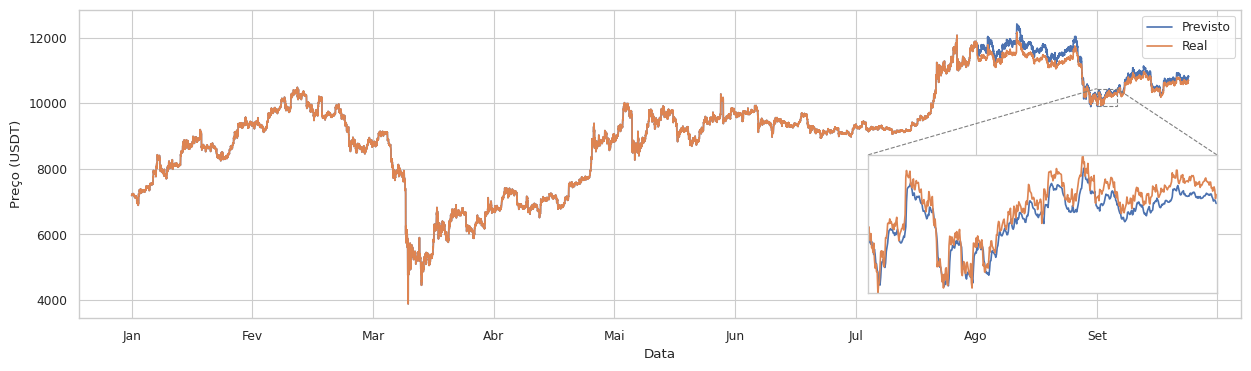

In [87]:
# Configuração de tema Seaborn
sns.set_theme(rc={'figure.figsize': (15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

# Criando o gráfico principal
ax = df_forecast.plot(y=['y_true', 'y_hat'])
ax.set_ylabel("Preço (USDT)")
ax.set_xlabel("Data")
ax.legend(["Previsto","Real",])
ax.xaxis.set_major_locator(MultipleLocator(3000))
ax.set_xticklabels(['null','Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set'])  # Usando a coluna 'month' para rótulos

plt.grid(True)

zoom_start, zoom_end = 24000, 24500 

axins = inset_axes(ax, width="30%", height="45%", loc="lower right", borderpad=2)

df_forecast.iloc[zoom_start:zoom_end].plot(ax=axins, legend=False)

# Ajuste do eixo Y na lupa para uma melhor visualização
y_min = min(df_forecast['y_true'][zoom_start:zoom_end].min(), df_forecast['y_hat'][zoom_start:zoom_end].min()) - 0.1
y_max = max(df_forecast['y_true'][zoom_start:zoom_end].max(), df_forecast['y_hat'][zoom_start:zoom_end].max()) + 0.1
axins.set_ylim(y_min, y_max)
axins.set_xlim(zoom_start, zoom_end)

axins.set_xlabel('')
axins.set_ylabel('')
axins.set_xticks([])
axins.set_yticks([])

# Marcar a área da lupa no gráfico principal
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5", linestyle='--')

# Exibindo o gráfico final
plt.show()